<a href="https://colab.research.google.com/github/marcus-tam/G12_419M_SentimentAnalysis/blob/marcus/g12_stockprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!pip install yfinance
!pip install helper
!pip install metrics

In [38]:
from tkinter import *
import time
import nltk
import re
import requests
import json
from requests.exceptions import HTTPError
from nltk.corpus import wordnet
import codecs
import yfinance as yf
from numpy import exp
import numpy as np
import pandas as pd
import time
import datetime
import numpy as np
import metrics
#split data into training and testing set
from sklearn.model_selection import train_test_split
#used for scale data into different range
from sklearn.preprocessing import scale
#to make a support vector machine for classification
from sklearn.svm import SVC
#library to do the cross validation
from sklearn.model_selection import GridSearchCV
#to  view the data graphically
from sklearn.metrics import plot_confusion_matrix
#to calculate the accuracy, will do the match one by one
from sklearn.metrics import accuracy_score
#plot graph
import matplotlib.pyplot as plt
import matplotlib.table as table
# tells matplotlib to embed plots within the notebook
from sklearn.decomposition import PCA
from keras.utils import plot_model

In [39]:
from google.colab import files
uploaded = files.upload()
%ls

DataByDate.zip        testBRK.BByDate.txt  trainBRK.BByDate.txt
dataset_combined.zip  testMCDByDate.txt    trainMCDByDate.txt
sample_data/          testPFEByDate.txt    trainPFEByDate.txt
testAAPLByDate.txt    trainAAPLByDate.txt


In [24]:
!unzip DataByDate


Archive:  DataByDate.zip
  inflating: testAAPLByDate.txt      
  inflating: testBRK.BByDate.txt     
  inflating: testMCDByDate.txt       
  inflating: testPFEByDate.txt       
  inflating: trainAAPLByDate.txt     
  inflating: trainBRK.BByDate.txt    
  inflating: trainMCDByDate.txt      
  inflating: trainPFEByDate.txt      


In [40]:
def get_frequent_keyword(filepath,filepath_new):
    f=open(filepath,"r")
    str=f.readline()
    count=1
    # list of word sort by first character
    keywords=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
    keywords_count=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
    while str!="":
        line_splited=str.split("	")
        word_str=line_splited[len(line_splited)-2]
        word_list=word_str.split(" ")
        for word in word_list:
            if_exist=False
            if len(word)==0:
  ##              print("error at line",count,"the short word is in",word_str)
                continue
            try:
                index=ord(word[0])-97
            except:
  ##              print("error at line",count,"the short word is in",word_str)
                continue
            if index<0 or index>25:
  ##              print("error at line",count,"the unrecognized word is",word)
                continue

            for i in range(0,len(keywords[index])):
                if keywords[index][i]==word:
                    keywords_count[index][i]+=1
                    if_exist=True
                    break
            if not if_exist:
                keywords[index].append(word)
                keywords_count[index].append(1)
        str=f.readline()
        count+=1
    f.close()
    sum_frequent=0
    sum=0
    frequent_keywords=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
    for i in range (0,26):
        for j in range(0,len(keywords[i])):
            sum+=1
            if keywords_count[i][j]<=9999 and keywords_count[i][j]>=10:
                # print(keywords[i][j])
                sum_frequent+=1
                frequent_keywords[i].append(keywords[i][j])
    content=""
    for keyword_list in frequent_keywords:
        result=",".join(i for i in keyword_list) 
        content+=result+"\n"
    file_new = open(filepath_new, "w")
    file_new.write(content)
    file_new.close()
    print("Get frequent key process done")
    # print(sum)
    # print(sum_frequent)

In [41]:
def syns_process(filename,file_new):
    keywords=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
    content=""
    # read old file
    file_old = open(filename,"r")
    str=file_old.readline()
    count=1
    while str!="":
        line_splited=str.split("	")
        word_str=line_splited[len(line_splited)-2]
        word_list=word_str.split(" ")
        for b in range(len(word_list)):
            syns = wordnet.synsets(word_list[b])
            # print(syns[0].name())
            syns_list=[]
            if_exist=False
            for i in range (0,len(syns)):
                for j in range (0,len(syns[i].lemmas())):
                    word_temp=syns[i].lemmas()[j].name()
                    if len(word_temp)==0:
   ##                     print("the short word is in",word_temp)
                        continue
                    try:
                        index=ord(word_temp[0])-97
                    except:
                          continue
  ##                      print("the short word is in",word_temp)
                    if index<0 or index>25:
                        # print("the unrecognized word is",word_temp)
                        continue
                    for a in range(0,len(keywords[index])):
                        if keywords[index][a]==word_temp:
                            word_list[b]=word_temp
                            # print("changed from", word_list[b],"to",word_temp)
                            if_exist=True
                            break
                    if if_exist:
                        break
                if if_exist:
                    break
            if not if_exist:
                if len(word_list[b])==0:
                    # print("the short word is in",word_list[b])
                    continue
                try:
                    index=ord(word_list[b][0])-97
                except:
                    print("the short word is in",word_list[b])
                    continue
                if index<0 or index>25:
                    # print("the unrecognized word is",word_list[b])
                    continue
                keywords[index].append(word_list[b]) 
        line_splited[len(line_splited)-2]=" ".join(i for i in word_list)
        if line_splited[len(line_splited)-1]!="\n":
            line_splited[len(line_splited)-1]="\n"
        result="	".join(i for i in line_splited)
        content+=result
        str=file_old.readline()
        count+=1
        # print(count)
    file_old.close()
    #  write new file
    file_new = open(file_new, "w")
    file_new.write(content)
    file_new.close()
    print("Synomys process done")

In [42]:
def get_file_dictionary(filepath,filepath_new):
    f=open(filepath,"r",encoding="UTF-8", errors="ignore")
    str=f.readline()
    count=1
    # list of word sort by first character
    keywords=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
    while str!="":
        line_splited=str.split("	")
        word_str=line_splited[len(line_splited)-2]
        word_list=word_str.split(" ")
        for word in word_list:
            if_exist=False
            if len(word)==0:
  ##              print("error at line",count,"the short word is in",word_str)
                continue
            try:
                index=ord(word[0])-97
            except:
  ##              print("error at line",count,"the short word is in",word_str)
                continue
            if index<0 or index>25:
  ##              print("error at line",count,"the unrecognized word is",word)
                continue
            for keyword in keywords[index]:
                if keyword==word:
                    if_exist=True
                    break
            if not if_exist:
                keywords[index].append(word)
        str=f.readline()
        count+=1
    f.close()
    content=""
    sum=0
    for keyword_list in keywords:
        sum+=len(keyword_list)
        result=",".join(i for i in keyword_list) 
        content+=result+"\n"
    file_new = open(filepath_new, "w")
    file_new.write(content)
    file_new.close()
    print(sum)

In [43]:
def process_original_data(filepath_old,filepath_new):
    content=""
    # read old file
    file_old = open(filepath_old,"r")
    count=1
    str=file_old.readline()
    while str!="":
        line_splited=str.split("    ")
        if line_splited[len(line_splited)-1]!="\n":
            line_splited[len(line_splited)-1]="\n"
        result="    ".join(i for i in line_splited)
        content+=result
        try:
            str=file_old.readline()
        except:
            count+=1
            # print (count)
            continue
        count+=1


    file_old.close()
    #  write new file
    file_new = open(filepath_new, "w")
    file_new.write(content)
    print("Original file process done")
    file_new.close()

In [44]:
def sigmoid(x):
    sig = 1 / (1 + exp(-5*x))
    return round(sig)

In [45]:
def get_stock_price(stockname,start):
    ticker = stockname
    msft = yf.Ticker(ticker)
    hist = msft.history(period="max",start=start,interval="1d")
    price_data=hist.values
    price_date=hist.index
    result=[]
    # print(hist)
    pre_date=start
    for i in range (0,len(price_date)):
        temp=[]
        current_data=price_date[i].strftime('%Y-%m-%d')
        
        if date_difference(pre_date,current_data)>=2:
            six=(price_date[i-1] +datetime.timedelta(days=1)).strftime('%Y-%m-%d')
            temp.append(six)
            difference=(price_data[i-1][3]-price_data[i][0])/2
            temp.append(difference)
            if difference>0:
                temp.append(0)
            else:
                temp.append(1)
            result.append(temp)
            # print(temp)
            temp=[]
            seven=(price_date[i-1] +datetime.timedelta(days=2)).strftime('%Y-%m-%d')
            temp.append(seven)
            difference= (price_data[i-1][3]-price_data[i][0])/4
            temp.append(difference)
            if difference>0:
                temp.append(0)
            else:
                temp.append(1)
            result.append(temp)
            # print(temp)
            temp=[]
        temp.append(current_data)
        difference=price_data[i][0]-price_data[i][3]
        temp.append(difference)
        if difference>0:
            temp.append(0)
        else:
            temp.append(1)
        result.append(temp)
        pre_date=current_data
    # print(result)
    return result

In [46]:
# def get_stock_price(stockname,start):
#     ticker = stockname
#     msft = yf.Ticker(ticker)
#     hist = msft.history(period="max",start=start,interval="1d")
#     hist['DailyDiff'] =  hist['Close'] - hist['Open']
#     hist['Bull/Bear'] = sigmoid(hist['DailyDiff'])
#     print(hist)

In [47]:
def date_difference(date1,date2):
    date1=time.strptime(date1,"%Y-%m-%d")
    date2=time.strptime(date2,"%Y-%m-%d")
    date1=datetime.datetime(date1[0],date1[1],date1[2])
    date2=datetime.datetime(date2[0],date2[1],date2[2])
    d=date2-date1
    return d.days

In [48]:
def bag_of_words(filepath_data,filepath_keywords):
    frequent_keywords=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
    keywords_vector=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
    keywords_vectors=[]
    file_keywords = open(filepath_keywords,"r")   
    for i in range (0,26) :
        str=file_keywords.readline()
        if(str==""):
            continue
        keywords_list=str.split(",")
        for keyword in keywords_list:
            frequent_keywords[i].append(keyword)
            keywords_vector[i].append(0)
    file_keywords.close()
    indent=0
    if filepath_data=="trainAAPL_new.txt":
        indent=5
    elif filepath_data=="trainAMZN_new.txt" or filepath_data=="trainPFE_new.txt":
        indent=2
    
    file_data = open(filepath_data,"r")  
    str=file_data.readline()
    count=1
    while str!="":
        ifdelete=True
        keywords_vector_temp=[]
        for i in range (0,26):
            keywords_vector_temp.append(np.zeros(len(keywords_vector[i])))      
        line_splited=str.split("	")
        word_str=line_splited[len(line_splited)-2]
        word_list=word_str.split(" ")
        for word in word_list:
            if len(word)==0:
                # print("word is",word)
                continue
            index=ord(word[0])-97
            if index<0 or index>25:
                # print(word,index)
                continue
            for i in range(0,len(frequent_keywords[index])):
                if frequent_keywords[index][i]==word:
                    ifdelete=False
                    keywords_vector_temp[index][i]+=1
                    break
        if ifdelete:
            # print(count)
            str=file_data.readline()
            count+=1
            continue
        temp=[]
        for vector in keywords_vector_temp:
            for value in vector:
                temp.append(value)
                # result=",".join(i+"" for i in temp)      
        temp.append(line_splited[1][0:10])
        keywords_vectors.append(temp)
        
        # print(temp)
        str=file_data.readline()
        count+=1
        # if indent!=0:
            # for i in range(0,indent):
            # if count>=10000:
            #     break
          # file_data.close()

    # numpy.savetxt('new_test2.csv', keywords_vectors, delimiter = ',')
  ##  print(keywords_vectors)
    return keywords_vectors

In [49]:
def trainTest(name, cutDateStr, symbol):
    datRaw = pd.read_csv(name, delimiter='\t', header = None) 
    df = pd.DataFrame(datRaw)
    df = df.drop(3,axis = 1) 
    df.columns = ['id','dateStr','tweet']
    df['dateStr'] = df.dateStr.str.slice(0,10)
    df['date'] = pd.to_datetime(df['dateStr'], format="%Y-%m-%d")
    cutDate = datetime.datetime.strptime(cutDateStr, "%Y-%m-%d")
    totalSet = df.loc[df['date'] > cutDate, 'tweet']
    lenTrain = round((totalSet.shape[0]) *0.7)
    trainSet = totalSet.tail(lenTrain)
    trainName = "train"+symbol + ".csv"
    trainSet.to_csv(trainName)
    lenTest = round((totalSet.shape[0])*0.3)
    testSet = totalSet.tail(lenTest)
    testName = "test"+symbol + ".csv"
    testSet.to_csv(testName)

In [50]:
def syns_test(word):
    syns = wordnet.synsets(word)
    # print(syns[0].name())
    syns_list=[]
    for i in range (0,len(syns)):
        for j in range (0,len(syns[i].lemmas())):
            syns_list.append(syns[i].lemmas()[j].name())
    syns_list.sort()
  ##  print(syns_list[0])

In [51]:
def svm(start,company,filename,filename_frequent,filename2):
    print("Doing svm prediction for",company)
    keywords_vectors=bag_of_words(filename,filename_frequent)
    # print(keywords_vectors[0])
    length=len(keywords_vectors[0])-1
    print("size of feature",length)
    stock_prediction=get_stock_price(company,start)
    d=date_difference(start,keywords_vectors[0][length])
    # index=date_difference(stock_prediction[d][0],keywords_vectors[0][length])
    # print(type(index))
    train_X=[]
    train_y=[]
    for i in range(0,len(keywords_vectors)):
        train_X.append(keywords_vectors[i][0:length])
        d=date_difference(start,keywords_vectors[i][length])+1
        # if date_difference(stock_prediction[d][0],keywords_vectors[i][length])==0:
        #     print(date_difference(stock_prediction[d][0],keywords_vectors[i][length]))
        # print(stock_prediction[d][0],keywords_vectors[i][length])
        #     print("date wrong")
        #     return
        temp=[]
        count0=0
        count1=0
        for a in range (0,7):
            if stock_prediction[d+a][2]==1:
                count1+=1
            elif stock_prediction[d+a][2]==0:
                count0+=1
        if count1>count0:
            # print(1)
            temp.append(1)
        else:
            # print(0)
            temp.append(0)

        # temp.append(stock_prediction[d][2])
        train_y.append(stock_prediction[d][2])
    train_X=np.array(train_X)
    train_y=np.array(train_y)

    keywords_vectors=bag_of_words(filename2,filename_frequent)
    length=len(keywords_vectors[0])-1
    d=date_difference(start,keywords_vectors[0][length])
    # index=date_difference(stock_prediction[d][0],keywords_vectors[0][length])
    # print(type(index))
    test_X=[]
    test_y=[]
    for i in range(0,len(keywords_vectors)):
        test_X.append(keywords_vectors[i][0:length])
        d=date_difference(start,keywords_vectors[i][length])+1
        # if date_difference(stock_prediction[d][0],keywords_vectors[i][length])==0:
        #     print(date_difference(stock_prediction[d][0],keywords_vectors[i][length]))
        # print(stock_prediction[d][0],keywords_vectors[i][length])
        #     print("date wrong")
        #     return
        temp=[]
        count0=0
        count1=0
        for a in range (0,7):
            if stock_prediction[d+a][2]==1:
                count1+=1
            elif stock_prediction[d+a][2]==0:
                count0+=1
        if count1>count0:
            # print(1)
            temp.append(1)
        else:
            # print(0)
            temp.append(0)

        # temp.append(stock_prediction[d][2])
        test_y.append(stock_prediction[d][2])
    test_X=np.array(test_X)
    test_y=np.array(test_y)
    # print("Train data size is",train_X.shape)
    # print("Test data size is",test_X.shape)
    

    train_X=scale(train_X)
    test_X=scale(test_X)
    bestacc_linear=0
    bestC_linear=0
    accs=np.zeros(100)
    params=np.zeros(100)
    bestacc_rbf=0
    bestC_rbf=0
    param=110
    rbf_svm=SVC(kernel='rbf',C=param)
    rbf_svm.fit(train_X,train_y)
    predict_y=rbf_svm.predict(test_X)
    acc = accuracy_score(test_y,predict_y)  
    # plot_confusion_matrix(rbf_svm, test_X, test_y, values_format = 'd', display_labels=['Spam', 'Not Spam'])
    # y_pred = rbf_svm.predict(test_X)
    # acc = metrics.accuracy_score(test_y, y_pred)
    print("The accracy is",acc)
    return rbf_svm, test_X, test_y
    # plt.plot(params, accs)
    # plt.axis([0, 1000, 0.5, 1])
    # plt.show()
    # print("best accuracy is",bestacc_rbf,"with value C=",bestC_rbf)

In [52]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [53]:
 def decorate(function):
   print("Beginning function")
   function
   print("End function")

# Only run specific blocks from this point on. 

In [ ]:
# MCD COMBINED
svm, test_X, test_y = svm("2020-12-09","MCD","trainMCDCombination_new.txt","MCDCombination_frequent.txt","testMCDCombination_new.txt")
plot_confusion_matrix(svm, test_X, test_y, values_format = 'd', display_labels=['Bullish', 'Bearish'])

Doing svm prediction for MCD
size of feature 2098


In [ ]:
# PFE COMBINED
svm, test_X, test_y = svm("2020-12-09","PFE","trainPFECombination_new.txt","PFECombination_frequent.txt","testPFECombination_new.txt")
# plot_confusion_matrix(svm, test_X, test_y, values_format = 'd', display_labels=['Bullish', 'Bearish'])

Doing svm prediction for PFE
size of feature 3029


Doing svm prediction for MCD
size of feature 699
The accracy is 0.6604036186499652


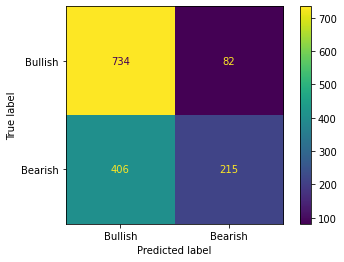

In [ ]:

# decorate(process_original_data("trainRedditMCD.txt","trainMCD_new.txt"))
# decorate(process_original_data("testRedditMCD.txt","testMCD_new.txt"))
# decorate(syns_process("trainMCD_new.txt","trainMCD_new.txt"))
# decorate(get_frequent_keyword("trainMCD_new.txt" ,"MCD_frequent.txt"))
svm, test_X, test_y = svm("2020-12-09","MCD","trainRedditMCD_new.txt","RedditMCD_frequent.txt","testRedditMCD_new.txt")
plot_confusion_matrix(svm, test_X, test_y, values_format = 'd', display_labels=['Bullish', 'Bearish'])


Doing svm prediction for BRK-B
size of feature 699
The accracy is 0.6666666666666666


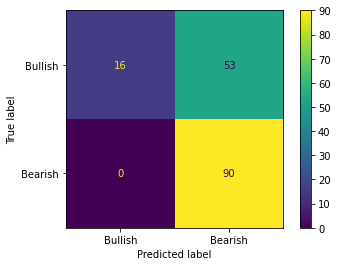

In [ ]:
# BRK.B
svm, test_X, test_y = svm("2020-12-09","BRK-B","trainRedditBRK.B_new.txt","RedditBRK.B_frequent.txt","testRedditBRK.B_new.txt")
plot_confusion_matrix(svm, test_X, test_y, values_format = 'd', display_labels=['Bullish', 'Bearish'])

Doing svm prediction for PFE


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The accracy is 0.7192771084337349


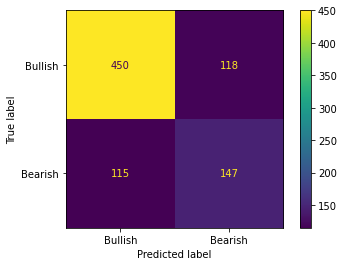

In [ ]:
# PFE
svm, test_X, test_y = svm("2020-12-09","PFE","trainRedditPFE_new.txt","RedditPFE_frequent.txt","testRedditPFE_new.txt")
plot_confusion_matrix(svm, test_X, test_y, values_format = 'd', display_labels=['Bullish', 'Bearish'])

Doing svm prediction for AAPL
size of feature 3710
The accracy is 0.6617305458768873


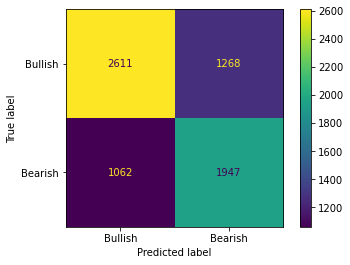

In [ ]:
# AAPL
svm, test_X, test_y = svm("2020-12-09","AAPL","trainRedditAAPL_new.txt","RedditAAPL_frequent.txt","testRedditAAPL_new.txt")
plot_confusion_matrix(svm, test_X, test_y, values_format = 'd', display_labels=['Bullish', 'Bearish'])

In [ ]:
# process_original_data("trainAAPL.txt","trainAAPL_new.txt")
# process_original_data("testAAPL.txt","testAAPL_new.txt")
# syns_process("trainAAPL_new.txt","trainAAPL_new.txt" )
# get_frequent_keyword("trainAAPL_new.txt" ,"AAPL_frequent.txt")
svm, test_X, test_y = svm("2020-12-09","AAPL","trainAAPL_new.txt","AAPL_frequent.txt","testAAPL_new.txt")
plot_confusion_matrix(svm, test_X, test_y, values_format = 'd', display_labels=['Bullish', 'Bearish'])


Doing svm prediction for MCD


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The accracy is 0.8111217641418984


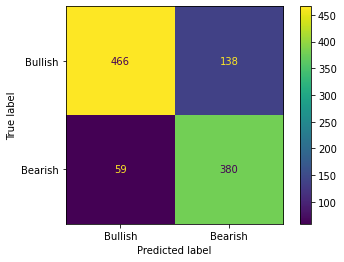

In [ ]:
svm, test_X, test_y = svm("2020-12-09","MCD","trainMCD_new.txt","MCD_frequent.txt","testMCD_new.txt")
plot_confusion_matrix(svm, test_X, test_y, values_format = 'd', display_labels=['Bullish', 'Bearish'])


Doing svm prediction for BRK-B
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

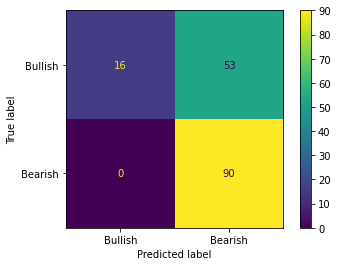

In [ ]:
svm, test_X, test_y = svm("2020-12-09","BRK-B","trainRedditBRK.B_new.txt","RedditBRK.B_frequent.txt","testRedditBRK.B_new.txt")
plot_confusion_matrix(svm, test_X, test_y, values_format = 'd', display_labels=['Bullish', 'Bearish'])


In [ ]:
test_X.shape

NameError: ignored

In [ ]:
# process_original_data("testBRK.B.txt","testBRKB_new.txt")
# process_original_data("trainBRK.B.txt","trainBRKB_new.txt")
# syns_process("trainBRKB_new.txt","trainBRKB_new.txt")
# get_frequent_keyword("trainBRKB_new.txt" ,"BRKB_frequent.txt")
svm, test_X, test_y = svm("2020-12-09","BRK-B","trainBRKB_new (2).txt","BRKB_frequent (1).txt","testBRKB_new (1).txt")
pcm = plot_confusion_matrix(svm, test_X, test_y, values_format = 'd', display_labels=['Bullish', 'Bearish'])
print(pcm.confusion_matrix)

Doing svm prediction for BRK-B


FileNotFoundError: ignored

In [ ]:
f = open('trainRedditMCD (1).txt', 'r')
file_contents = f.read()
print (file_contents)
f.close()


Doing svm prediction for MCD


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The accracy is 0.8111217641418984
[[466 138]
 [ 59 380]]


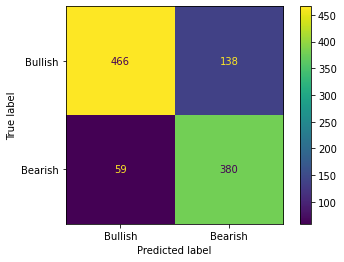

In [ ]:
svm, test_X, test_y = svm("2020-12-09","MCD","trainMCD_new.txt","MCD_frequent.txt","testMCD_new.txt")
pcm = plot_confusion_matrix(svm, test_X, test_y, values_format = 'd', display_labels=['Bullish', 'Bearish'])
print(pcm.confusion_matrix)
# print(metrics)

Doing svm prediction for MCD


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The accracy is 0.6604036186499652
[[734  82]
 [406 215]]


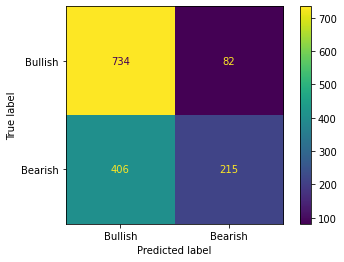

In [ ]:
svm, test_X, test_y = svm("2020-12-09","MCD","trainRedditMCD_new.txt","RedditMCD_frequent.txt","testRedditMCD_new.txt")
pcm = plot_confusion_matrix(svm, test_X, test_y, values_format = 'd', display_labels=['Bullish', 'Bearish'])
print(pcm.confusion_matrix)

In [ ]:
svm, test_X, test_y = svm("2020-12-09","PFE","trainPFE_new.txt","PFE_frequent.txt","testPFE_new.txt")
pcm = plot_confusion_matrix(svm, test_X, test_y, values_format = 'd', display_labels=['Bullish', 'Bearish'])
print(pcm.confusion_matrix)
print(classification_report(y_test, predicted))

Doing svm prediction for PFE


NameError: ignored

In [19]:
# CNN attempt 
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten, Input, InputLayer
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from tensorflow import keras


In [ ]:
# TPU Initialization 
import tensorflow as tf

import os
import tensorflow_datasets as tfds

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Initializing the TPU system: grpc://10.120.110.146:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.120.110.146:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


In [20]:
# Load data - taken from John's SVM because I'm not entirely sure how it works
def load_data(start,company,filename,filename_frequent,filename2):
    keywords_vectors=bag_of_words(filename,filename_frequent)
    # print(keywords_vectors[0])
    length=len(keywords_vectors[0])-1
    # print("size of feature",length)
    stock_prediction=get_stock_price(company,start)
    d=date_difference(start,keywords_vectors[0][length])
    # index=date_difference(stock_prediction[d][0],keywords_vectors[0][length])
    # print(type(index))
    train_X=[]
    train_y=[]
    for i in range(0,len(keywords_vectors)):
        train_X.append(keywords_vectors[i][0:length])
        d=date_difference(start,keywords_vectors[i][length])+1
        # if date_difference(stock_prediction[d][0],keywords_vectors[i][length])==0:
        #     print(date_difference(stock_prediction[d][0],keywords_vectors[i][length]))
        # print(stock_prediction[d][0],keywords_vectors[i][length])
        #     print("date wrong")
        #     return
        temp=[]
        count0=0
        count1=0
        for a in range (0,7):
            if stock_prediction[d+a][2]==1:
                count1+=1
            elif stock_prediction[d+a][2]==0:
                count0+=1
        if count1>count0:
            # print(1)
            temp.append(1)
        else:
            # print(0)
            temp.append(0)

        # temp.append(stock_prediction[d][2])
        train_y.append(stock_prediction[d][2])
    train_X=np.array(train_X)
    train_y=np.array(train_y)

    keywords_vectors=bag_of_words(filename2,filename_frequent)
    length=len(keywords_vectors[0])-1
    d=date_difference(start,keywords_vectors[0][length])
    # index=date_difference(stock_prediction[d][0],keywords_vectors[0][length])
    # print(type(index))
    test_X=[]
    test_y=[]
    for i in range(0,len(keywords_vectors)):
        test_X.append(keywords_vectors[i][0:length])
        d=date_difference(start,keywords_vectors[i][length])+1
        # if date_difference(stock_prediction[d][0],keywords_vectors[i][length])==0:
        #     print(date_difference(stock_prediction[d][0],keywords_vectors[i][length]))
        # print(stock_prediction[d][0],keywords_vectors[i][length])
        #     print("date wrong")
        #     return
        temp=[]
        count0=0
        count1=0
        for a in range (0,7):
            if stock_prediction[d+a][2]==1:
                count1+=1
            elif stock_prediction[d+a][2]==0:
                count0+=1
        if count1>count0:
            # print(1)
            temp.append(1)
        else:
            # print(0)
            temp.append(0)

        # temp.append(stock_prediction[d][2])
        test_y.append(stock_prediction[d][2])
    test_X=np.array(test_X)
    test_y=np.array(test_y)
    return train_X, test_X, test_y, train_y

In [ ]:
from google.colab import files
uploaded = files.upload()
%ls

AAPL_frequent.txt         testBRKB_new.txt         trainAMZN.txt
AMZN_frequent.txt         testBRK.B.txt            trainBRKB_new.txt
BRKB_frequent.txt         testMCD_new.txt          trainBRK.B.txt
MCD_frequent.txt          testMCD.txt              trainMCD_new.txt
model_3.png               testPFE_new.txt          trainMCD.txt
PFE_frequent.txt          testPFE.txt              trainPFE_new.txt
PFE_keyword_dict.txt      testRedditAAPL_new.txt   trainPFE.txt
PFE_new.txt               testRedditAAPL.txt       trainRedditAAPL_new.txt
RedditAAPL_frequent.txt   testRedditBRK.B_new.txt  trainRedditAAPL.txt
RedditBRK.B_frequent.txt  testRedditBRK.B.txt      trainRedditBRK.B_new.txt
RedditMCD_frequent.txt    testRedditBRK_new.txt    trainRedditBRK.B.txt
RedditPFE_frequent.txt    testRedditMCD_new.txt    trainRedditMCD_new.txt
sample_data/              testRedditMCD.txt        trainRedditMCD.txt
stocktwitsBRK.B_1.txt     testRedditPFE_new.txt    trainRedditPFE_new.txt
testAAPL_new.txt        

In [ ]:
def create_baseline():
  model = Sequential()
  # model.add(InputLayer(input_shape=(train_X.shape[0], train_X.shape[1])))
  model.add(InputLayer(input_shape=(train_X.shape[1], 1)))
  
  # model.add(LSTM(units=50, return_sequences=True, input_shape=(train_X.shape[1], 1)))
  # model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(train_X.shape[1], 1)))
  model.add(Conv1D(activation='relu', filters=32, kernel_size=1, padding="same"))
  model.add(MaxPooling1D(pool_size=1, padding="same"))
  model.add(LSTM(units=64, return_sequences=True, activation="relu"))
  # model.add(Flatten())
  model.add(Dense(units=1))

  # model.add(Dropout(0.2))
  # model.add(LSTM(units=50, return_sequences=True))
  # model.add(Dropout(0.2))
  # model.add(LSTM(units=50))
  # model.add(Dropout(0.2))
  # # model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
  # # model.add(MaxPooling1D(pool_size=2))
  # model.add(Flatten())
  # model.add(Dense(50, activation='relu'))
  # model.add(Dense(1))
  # model.compile(optimizer='adam', loss='mse')

  opt = keras.optimizers.Adam(learning_rate = 0.001)
  # model.add(Dense(units=1))

	# Compile model
  model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['accuracy'])
  return model

In [ ]:
# get train, test  X, y / Prepare data
# scaler = MinMaxScaler(feature_range=(0,1))
# scaled_data = scaler.fit_transform()
# train_X, test_X, test_y, train_y = load_data("2020-12-09","MCD","trainMCD_new.txt","MCD_frequent.txt","testMCD_new.txt")
## train_X, test_X, test_y, train_y = load_data("2020-12-09","AAPL","trainAAPL_new.txt","AAPL_frequent.txt","testAAPL_new.txt")
## train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
## train_X.shape
# MCD COMBINED
train_X, test_X, test_y, train_y = load_data("2020-12-09","MCD","trainMCDCombination_new.txt","MCDCombination_frequent.txt","testMCDCombination_new.txt")
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
train_X.shape

(5797, 2098, 1)

In [ ]:
def create_baseline_aa():
  model = Sequential()
  model.add(InputLayer(input_shape=(train_X.shape[1], 1)))
  model.add(Conv1D(activation='relu', filters=train_X.shape[1], kernel_size=1, padding="same"))
  model.add(MaxPooling1D(pool_size=1, padding="same"))
  model.add(LSTM(units=train_X.shape[1], return_sequences=True, activation="relu"))
  model.add(Dense(units=1))  
  opt = keras.optimizers.Adam(learning_rate = 0.001)
  model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['accuracy'])
  return model


In [ ]:
model_a = create_baseline_aa()
model_a.fit(train_X, train_y, epochs=10, batch_size = 64)

Epoch 1/10


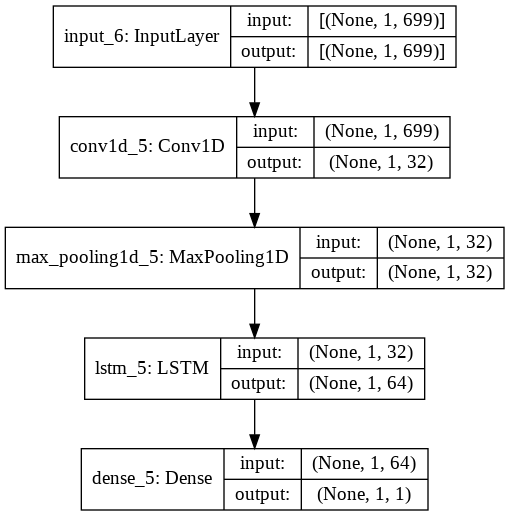

In [ ]:
(plot_model(model_a, to_file = 'model_a.png', show_shapes=True))
from IPython.display import display, Image

path = "model_a.png"

img = Image(path)
display(img)

In [ ]:
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))
scores = model_a.evaluate(test_X, test_y)
print("Accuracy: %.2f%%" % (scores[1]*100))

ValueError: ignored

In [ ]:
# Fit data and train model
model = create_baseline()
model.fit(train_X, train_y, epochs=10, batch_size = 256)


Epoch 1/10
23/23 [==============================] - 121s 5s/step - loss: nan - accuracy: 0.4749
Epoch 2/10
23/23 [==============================] - 122s 5s/step - loss: nan - accuracy: 0.4747
Epoch 3/10
23/23 [==============================] - 120s 5s/step - loss: nan - accuracy: 0.4796
Epoch 4/10
23/23 [==============================] - 128s 6s/step - loss: nan - accuracy: 0.4763
Epoch 5/10
23/23 [==============================] - 119s 5s/step - loss: nan - accuracy: 0.4757
Epoch 6/10
23/23 [==============================] - 119s 5s/step - loss: nan - accuracy: 0.4758
Epoch 7/10
23/23 [==============================] - 119s 5s/step - loss: nan - accuracy: 0.4819
Epoch 8/10
23/23 [==============================] - 118s 5s/step - loss: nan - accuracy: 0.4757
Epoch 9/10
23/23 [==============================] - 119s 5s/step - loss: nan - accuracy: 0.4765
Epoch 10/10
23/23 [==============================] - 119s 5s/step - loss: nan - accuracy: 0.4733


In [ ]:
print(plot_model(model, show_shapes=True))

NameError: ignored

In [ ]:
from keras.callbacks import EarlyStopping


def create_baseline3():
  model = Sequential()
  model.add(InputLayer(input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Conv1D(activation='tanh', filters=32, kernel_size=1, padding="same"))
  model.add(MaxPooling1D(pool_size=1, padding="same"))
  model.add(LSTM(units=64, return_sequences=True, activation="tanh"))
  # model.add(Dropout(0.2))
  # model.add(LSTM(units=50, return_sequences=True))
  # model.add(Dropout(0.2))
  # model.add(LSTM(units=50))
  # model.add(Dropout(0.2))
  model.add(Dense(units=1))

  opt = keras.optimizers.Adam(learning_rate = 0.001)
  # model.add(Dense(units=1))

	# Compile model
  model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

  es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
  return model

In [ ]:
model3 = create_baseline3()
model3.fit(train_X, train_y, epochs=50, batch_size = 128, use_multiprocessing=True)


Epoch 1/50
16/16 [==============================] - 17s 903ms/step - loss: 0.3469 - accuracy: 0.6019
Epoch 2/50
16/16 [==============================] - 16s 994ms/step - loss: 0.2403 - accuracy: 0.6146
Epoch 3/50
16/16 [==============================] - 16s 987ms/step - loss: 0.2349 - accuracy: 0.6268
Epoch 4/50
16/16 [==============================] - 16s 964ms/step - loss: 0.2325 - accuracy: 0.6354
Epoch 5/50
16/16 [==============================] - 16s 988ms/step - loss: 0.2346 - accuracy: 0.6258
Epoch 6/50
16/16 [==============================] - 16s 1s/step - loss: 0.2354 - accuracy: 0.6310
Epoch 7/50
16/16 [==============================] - 16s 968ms/step - loss: 0.2383 - accuracy: 0.6119
Epoch 8/50
16/16 [==============================] - 16s 990ms/step - loss: 0.2349 - accuracy: 0.6308
Epoch 9/50
16/16 [==============================] - 16s 964ms/step - loss: 0.2335 - accuracy: 0.6335
Epoch 10/50
16/16 [==============================] - 15s 955ms/step - loss: 0.2381 - accuracy:

In [ ]:
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))
scores = model3.evaluate(test_X, test_y)
print("Accuracy: %.2f%%" % (scores[1]*100))

26/26 [==============================] - 3s 98ms/step - loss: 0.2206 - accuracy: 0.6829
Accuracy: 68.29%


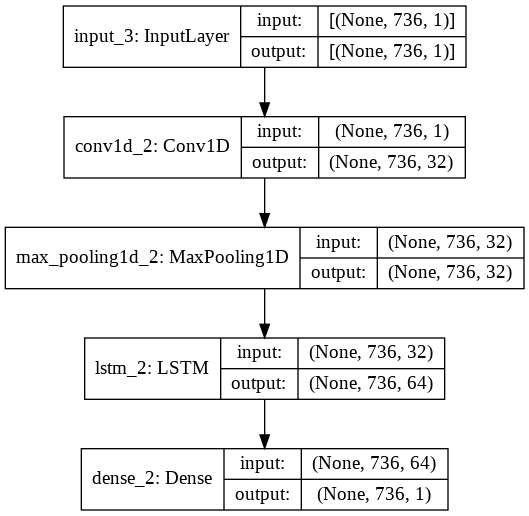

In [ ]:
(plot_model(model3, to_file = 'model_3.png', show_shapes=True))
from IPython.display import display, Image

path = "model_3.png"

img = Image(path)
display(img)

In [ ]:
# Logistic regression
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import L1L2

In [ ]:
# Supposedly logistic regression in keras
def create_baseline2():
  model = Sequential()
  model.add(Dense(units = 1, input_shape=(train_X.shape[1], 1), activation='sigmoid'))

	# Compile model
  model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['binary_accuracy'])
  return model

In [ ]:
# Fit data
model2 = create_baseline2()
model2.fit(train_X, train_y, epochs=100, batch_size = 64)

Epoch 1/100
53/53 [==============================] - 1s 5ms/step - loss: 0.6981 - binary_accuracy: 0.4841
Epoch 2/100
53/53 [==============================] - 0s 5ms/step - loss: 0.6976 - binary_accuracy: 0.4933
Epoch 3/100
53/53 [==============================] - 0s 5ms/step - loss: 0.6969 - binary_accuracy: 0.5020
Epoch 4/100
53/53 [==============================] - 0s 5ms/step - loss: 0.6967 - binary_accuracy: 0.4887
Epoch 5/100
53/53 [==============================] - 0s 5ms/step - loss: 0.6964 - binary_accuracy: 0.4897
Epoch 6/100
53/53 [==============================] - 0s 5ms/step - loss: 0.6956 - binary_accuracy: 0.4956
Epoch 7/100
53/53 [==============================] - 0s 4ms/step - loss: 0.6946 - binary_accuracy: 0.5039
Epoch 8/100
53/53 [==============================] - 0s 5ms/step - loss: 0.6957 - binary_accuracy: 0.4834
Epoch 9/100
53/53 [==============================] - 0s 4ms/step - loss: 0.6941 - binary_accuracy: 0.5032
Epoch 10/100
53/53 [==========================

In [ ]:
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))
scores = model2.evaluate(test_X, test_y)
print("Accuracy: %.2f%%" % (scores[1]*100))

45/45 [==============================] - 0s 2ms/step - loss: 0.7004 - binary_accuracy: 0.4322
Accuracy: 43.22%


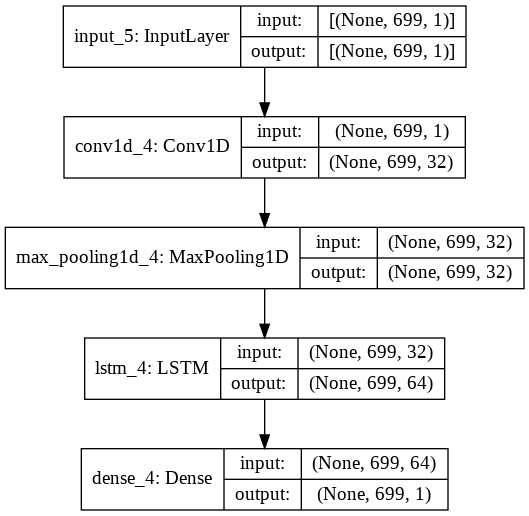

In [ ]:
(plot_model(model, to_file = 'model.png', show_shapes=True))
from IPython.display import display, Image

path = "model.png"

img = Image(path)
display(img)

In [ ]:
X_train, X_test, y_test, y_train = load_data("2020-12-09","PFE","trainPFE_new.txt","PFE_frequent.txt","testPFE_new.txt")
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_train.shape = np.reshape(X_train, (X_train[0], X_train[1]))

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
sk_lr_model = LogisticRegression()
sk_lr_model = sk_lr_model.fit(X_train, y_train)

sk_probability = sk_lr_model.predict_proba(X_test)

sk_probability = sk_lr_model.predict_proba(X_test)
print(f"probability: {sk_probability}")

predicted = sk_lr_model.predict(X_test)

print(plot_confusion_matrix(sk_lr_model, X_test, y_test, values_format = 'd', display_labels=['Bullish', 'Bearish']))
print(classification_report(y_test, predicted))
print(f"Accuracy: {sk_lr_model.score(X_test, y_test) * 100}%")

In [ ]:
prediction_prices2 = model2.predict(test_X)
count2 = 0
# show the inputs and predicted outputs
for i in range(len(prediction_prices2)):
  print(f"Actual = {test_y[i]}, Predicted={np.round(prediction_prices2[i], 0)}")
  if test_y[i] == np.round(prediction_prices2[i], 1):
    count2+=1


print(f"Accuracy: {(count2/len(prediction_prices2)) * 100}")

(461, 1)
Actual = 0, Predicted=[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1

ValueError: ignored

In [ ]:

estimator = KerasClassifier(build_fn=create_baseline2, epochs=10, batch_size=32, verbose=0)
results = cross_val_score(estimator, test_X, test_y, cv=3)


In [ ]:
print(results)

[0.58620691 0.7011494  0.44956774]


In [ ]:
0

0

In [ ]:
# So I don't have to keep scrolling
from google.colab import files
uploaded = files.upload()
%ls

Saving MCD_frequent.txt to MCD_frequent (2).txt
Saving testRedditMCD_new.txt to testRedditMCD_new (1).txt
Saving trainMCD_new.txt to trainMCD_new (2).txt
'MCD_frequent (1).txt'   testMCD_new.txt             'trainMCD_new (2).txt'
'MCD_frequent (2).txt'   testPFE_new.txt              trainMCD_new.txt
 MCD_frequent.txt       'testRedditMCD_new (1).txt'   trainPFE_new.txt
 PFE_frequent.txt        testRedditMCD_new.txt
 sample_data/           'trainMCD_new (1).txt'


In [ ]:
f = open("trainPFE_new.txt", 'r')
print(f.read())

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# PyTorch LSTM Model
import torch
import torch.nn as nn


In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [ ]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)


LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [ ]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

NameError: ignored

In [ ]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [ ]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)


In [3]:
!pip install transformers_keras
!pip install simpletransformers

     |████████████████████████████████| 215kB 20.0MB/s 
     |████████████████████████████████| 3.3MB 49.1MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
     |████████████████████████████████| 1.2MB 50.5MB/s 
     |████████████████████████████████| 8.2MB 25.4MB/s 
     |████████████████████████████████| 1.8MB 47.3MB/s 
     |████████████████████████████████| 2.1MB 46.3MB/s 
     |████████████████████████████████| 225kB 58.2MB/s 
     |████████████████████████████████| 81kB 12.4MB/s 
     |████████████████████████████████| 122kB 60.5MB/s 
     |████████████████████████████████| 4.2MB 49.8MB/s 
     |████████████████████████████████| 112kB 61.7MB/s 
     |████████████████████████████████| 163kB 55.3MB/s 
     |████████████████████████████████| 81kB 12.7MB/s 
     |████████████████████████████████| 102kB 13.8MB/s 
     |████████████████████████████████| 133kB 46.8MB/s 
     |████████████████████████████████| 901kB 51.2MB/s 
     |████████████████████████████████| 112kB 55.5MB

In [4]:

from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import logging


logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# Preparing train data
train_data = [
    ["Aragorn was the heir of Isildur", 1],
    ["Frodo was the heir of Isildur", 0],
]
train_df = pd.DataFrame(train_data)
train_df.columns = ["text", "labels"]

# Preparing eval data
eval_data = [
    ["Theoden was the king of Rohan", 1],
    ["Merry was the king of Rohan", 0],
]
eval_df = pd.DataFrame(eval_data)
eval_df.columns = ["text", "labels"]

# Optional model configuration
model_args = ClassificationArgs(num_train_epochs=1)

# Create a ClassificationModel
model = ClassificationModel(
    "roberta", "roberta-base", args=model_args
)

# Train the model
model.train_model(train_df)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

# Make predictions with the model
predictions, raw_outputs = model.predict(["Sam was a Wizard"])

INFO:filelock:Lock 139660405833552 acquired on /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

INFO:filelock:Lock 139660405833552 released on /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock
INFO:filelock:Lock 139660405833488 acquired on /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7.lock


Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

INFO:filelock:Lock 139660405833488 released on /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7.lock
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of R

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

INFO:filelock:Lock 139660405960080 released on /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab.lock
INFO:filelock:Lock 139660266873744 acquired on /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock


Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

INFO:filelock:Lock 139660266873744 released on /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock
INFO:filelock:Lock 139660267003024 acquired on /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730.lock


Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

INFO:filelock:Lock 139660267003024 released on /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730.lock
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_2_2


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2


Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'tp': 0, 'tn': 1, 'fp': 0, 'fn': 1, 'auroc': 0.0, 'auprc': 0.5, 'eval_loss': 0.6942675113677979}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
predictions, raw_outputs = model.predict(["Aragorn was the heir of Isildur"])
print(predictions, raw_outputs)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[0] [[ 0.03207397 -0.0430603 ]]


In [10]:
import logging

import pandas as pd
from simpletransformers.seq2seq import Seq2SeqModel, Seq2SeqArgs


logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

train_data = [
    [
        "Perseus “Percy” Jackson is the main protagonist and the narrator of the Percy Jackson and the Olympians series.",
        "Percy is the protagonist of Percy Jackson and the Olympians",
    ],
    [
        "Annabeth Chase is one of the main protagonists in Percy Jackson and the Olympians.",
        "Annabeth is a protagonist in Percy Jackson and the Olympians.",
    ],
]

train_df = pd.DataFrame(train_data, columns=["input_text", "target_text"])

eval_data = [
    [
        "Grover Underwood is a satyr and the Lord of the Wild. He is the satyr who found the demigods Thalia Grace, Nico and Bianca di Angelo, Percy Jackson, Annabeth Chase, and Luke Castellan.",
        "Grover is a satyr who found many important demigods.",
    ],
    [
        "Thalia Grace is the daughter of Zeus, sister of Jason Grace. After several years as a pine tree on Half-Blood Hill, she got a new job leading the Hunters of Artemis.",
        "Thalia is the daughter of Zeus and leader of the Hunters of Artemis.",
    ],
]

eval_df = pd.DataFrame(eval_data, columns=["input_text", "target_text"])

# Configure the model
model_args = Seq2SeqArgs()
model_args.num_train_epochs = 200
model_args.evaluate_generated_text = True
model_args.evaluate_during_training = True
model_args.evaluate_during_training_verbose = True

model = Seq2SeqModel(
    encoder_decoder_type="bart",
    encoder_decoder_name="facebook/bart-large",
    args=model_args,
)

# Train the model
model.train_model(train_df, eval_data=eval_df)

# Evaluate the model
result = model.eval_model(eval_df)

# Use the model for prediction
print(
    model.predict(
        [
            "Tyson is a Cyclops, a son of Poseidon, and Percy Jackson’s half brother. He is the current general of the Cyclopes army."
        ]
    )
)

# Loading a saved model
model_reloaded = Seq2SeqModel(
    encoder_decoder_type="bart",
    encoder_decoder_name="outputs",
    args=model_args,
)

# Use the model for prediction
print(
    model_reloaded.predict(
        [
            "Tyson is a Cyclops, a son of Poseidon, and Percy Jackson’s half brother. He is the current general of the Cyclopes army."
        ]
    )
)

INFO:filelock:Lock 139659926785232 acquired on /root/.cache/huggingface/transformers/3f12fb71b844fcb7d591fdd4e55027da90d7b5dd6aa5430ad00ec6d76585f26c.01119ad5ed0734de7152ef51ba44fccefe008001bca9a6ddebeec1caf28f6bb8.lock


Downloading:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

INFO:filelock:Lock 139659926785232 released on /root/.cache/huggingface/transformers/3f12fb71b844fcb7d591fdd4e55027da90d7b5dd6aa5430ad00ec6d76585f26c.01119ad5ed0734de7152ef51ba44fccefe008001bca9a6ddebeec1caf28f6bb8.lock
INFO:filelock:Lock 139659926724816 acquired on /root/.cache/huggingface/transformers/d065edfe6954baf0b989a2063b26eb07e8c4d0b19354b5c74af9a51f5518df6e.6ca4df1a6ec59aa763989ceec10dff41dde19f0f0824b9f5d3fcd35a8abffdb2.lock


Downloading:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

INFO:filelock:Lock 139659926724816 released on /root/.cache/huggingface/transformers/d065edfe6954baf0b989a2063b26eb07e8c4d0b19354b5c74af9a51f5518df6e.6ca4df1a6ec59aa763989ceec10dff41dde19f0f0824b9f5d3fcd35a8abffdb2.lock
INFO:filelock:Lock 139659924858704 acquired on /root/.cache/huggingface/transformers/0d6fc8b2ef1860c1f8f0baff4b021e3426cc7d11b153f98e563b799603ee2f25.647b4548b6d9ea817e82e7a9231a320231a1c9ea24053cc9e758f3fe68216f05.lock


Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

INFO:filelock:Lock 139659924858704 released on /root/.cache/huggingface/transformers/0d6fc8b2ef1860c1f8f0baff4b021e3426cc7d11b153f98e563b799603ee2f25.647b4548b6d9ea817e82e7a9231a320231a1c9ea24053cc9e758f3fe68216f05.lock
INFO:filelock:Lock 139659924858960 acquired on /root/.cache/huggingface/transformers/6e75e35f0bdd15870c98387e13b93a8e100237eb33ad99c36277a0562bd6d850.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock


Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

INFO:filelock:Lock 139659924858960 released on /root/.cache/huggingface/transformers/6e75e35f0bdd15870c98387e13b93a8e100237eb33ad99c36277a0562bd6d850.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock
INFO:filelock:Lock 139659925245136 acquired on /root/.cache/huggingface/transformers/d94f53c8851dcda40774f97280e634b94b721a58e71bcc152b5f51d0d49a046a.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730.lock


Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

INFO:filelock:Lock 139659925245136 released on /root/.cache/huggingface/transformers/d94f53c8851dcda40774f97280e634b94b721a58e71bcc152b5f51d0d49a046a.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730.lock
INFO:filelock:Lock 139660267216848 acquired on /root/.cache/huggingface/transformers/1abf196c889c24daca2909359ca2090e5fcbfa21a9ea36d763f70adbafb500d7.67d01b18f2079bd75eac0b2f2e7235768c7f26bd728e7a855a1c5acae01a91a8.lock


Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

INFO:filelock:Lock 139660267216848 released on /root/.cache/huggingface/transformers/1abf196c889c24daca2909359ca2090e5fcbfa21a9ea36d763f70adbafb500d7.67d01b18f2079bd75eac0b2f2e7235768c7f26bd728e7a855a1c5acae01a91a8.lock


ValueError: ignored

In [22]:
!pip install -q tensorflow_datasets
!pip install -q tensorflow_text

     |████████████████████████████████| 3.4MB 8.0MB/s 


In [23]:
# Sample for Intro to Transfomers
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf

In [24]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteEFXB55/ted_hrlr_translate-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteEFXB55/ted_hrlr_translate-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteEFXB55/ted_hrlr_translate-test.tfrecord


Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [46]:
for pt_examples, en_examples in train_examples.batch(4).take(1):
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))

  print()

  for en in en_examples.numpy():
    print(en.decode('utf-8'))

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .
e esta rebeldia consciente é a razão pela qual eu , como agnóstica , posso ainda ter fé .

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .
and this conscious defiance is why i , as an agnostic , can still have faith .


In [47]:
model_name = "ted_hrlr_translate_pt_en_converter"
tf.keras.utils.get_file(
    f"{model_name}.zip",
    f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
    cache_dir='.', cache_subdir='', extract=True
)
tokenizers = tf.saved_model.load(model_name)

In [28]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]


['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [48]:
for en in en_examples.numpy():
  print(en.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .
and this conscious defiance is why i , as an agnostic , can still have faith .


In [50]:
encoded = tokenizers.en.tokenize(en_examples)

for row in encoded.to_list():
  print(row)

[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]
[2, 72, 81, 2508, 2159, 3072, 1282, 80, 192, 45, 13, 100, 111, 6040, 3176, 3186, 13, 94, 235, 89, 1938, 15, 3]


In [31]:
encoded = tokenizers.en.tokenize(en_examples)

for row in encoded.to_list():
  print(row)

[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


In [32]:
round_trip = tokenizers.en.detokenize(encoded)
for line in round_trip.numpy():
  print(line.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


In [33]:
tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability', b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage', b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip', b'##ity', b'.', b'[END]'], [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?', b'[END]'], [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for', b'curiosity', b'.', b'[END]']]>

In [34]:
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    # Convert from ragged to dense, padding with zeros.
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return pt, en

In [35]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [36]:
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [40]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates


def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


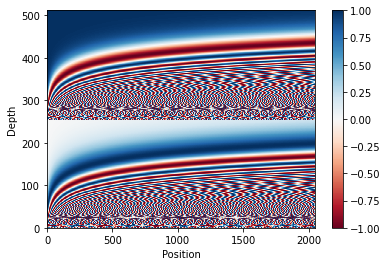

In [41]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [51]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [52]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [53]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [54]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [58]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights


In [60]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
  print('Attention weights are:')
  print(temp_attn)
  print('Output is:')
  print(temp_out)

In [61]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [62]:
# This query aligns with a repeated key (third and fourth),
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [63]:
# This query aligns equally with the first and second key,
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [ ]:
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

In [64]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [65]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [66]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [67]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [68]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [69]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [70]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

In [71]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [72]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [73]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [74]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [75]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.tokenizer = Encoder(num_layers, d_model, num_heads, dff,
                             input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inp, tar, training, enc_padding_mask,
           look_ahead_mask, dec_padding_mask):

    enc_output = self.tokenizer(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

In [76]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

In [77]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [78]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [79]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

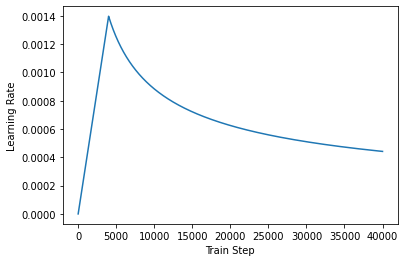

In [80]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [81]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [82]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [83]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [84]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size(),
    target_vocab_size=tokenizers.en.get_vocab_size(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [85]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

In [86]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

In [87]:
EPOCHS = 20

In [88]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp,
                                 True,
                                 enc_padding_mask,
                                 combined_mask,
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [89]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 8.8769 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.8239 Accuracy 0.0043
Epoch 1 Batch 100 Loss 8.7052 Accuracy 0.0246
Epoch 1 Batch 150 Loss 8.5821 Accuracy 0.0315
Epoch 1 Batch 200 Loss 8.4357 Accuracy 0.0353
Epoch 1 Batch 250 Loss 8.2637 Accuracy 0.0372
Epoch 1 Batch 300 Loss 8.0739 Accuracy 0.0391
Epoch 1 Batch 350 Loss 7.8771 Accuracy 0.0426
Epoch 1 Batch 400 Loss 7.6899 Accuracy 0.0511
Epoch 1 Batch 450 Loss 7.5238 Accuracy 0.0594
Epoch 1 Batch 500 Loss 7.3767 Accuracy 0.0675
Epoch 1 Batch 550 Loss 7.2423 Accuracy 0.0764
Epoch 1 Batch 600 Loss 7.1179 Accuracy 0.0848
Epoch 1 Batch 650 Loss 6.9998 Accuracy 0.0928
Epoch 1 Batch 700 Loss 6.8933 Accuracy 0.0998
Epoch 1 Batch 750 Loss 6.7960 Accuracy 0.1062
Epoch 1 Batch 800 Loss 6.7046 Accuracy 0.1122
Epoch 1 Loss 6.6889 Accuracy 0.1133
Time taken for 1 epoch: 114.13 secs

Epoch 2 Batch 0 Loss 5.4325 Accuracy 0.1896
Epoch 2 Batch 50 Loss 5.2336 Accuracy 0.2097
Epoch 2 Batch 100 Loss 5.2023 Accuracy 0.2155
Epoch 2 Batch

In [90]:
def evaluate(sentence, max_length=40):
  # inp sentence is portuguese, hence adding the start and end token
  sentence = tf.convert_to_tensor([sentence])
  sentence = tokenizers.pt.tokenize(sentence).to_tensor()

  encoder_input = sentence

  # as the target is english, the first word to the transformer should be the
  # english start token.
  start, end = tokenizers.en.tokenize([''])[0]
  output = tf.convert_to_tensor([start])
  output = tf.expand_dims(output, 0)

  for i in range(max_length):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input,
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.argmax(predictions, axis=-1)

    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

    # return the result if the predicted_id is equal to the end token
    if predicted_id == end:
      break

  # output.shape (1, tokens)
  text = tokenizers.en.detokenize(output)[0]  # shape: ()

  tokens = tokenizers.en.lookup(output)[0]

  return text, tokens, attention_weights

In [95]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [92]:
sentence = "este é um problema que temos que resolver."
ground_truth = "this is a problem we have to solve ."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to solve .
Ground truth   : this is a problem we have to solve .


In [93]:
sentence = "os meus vizinhos ouviram sobre esta ideia."
ground_truth = "and my neighboring homes heard about this idea ."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


In [94]:
sentence = "vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram."
ground_truth = "so i \'ll just share with you some stories very quickly of some magical things that have happened ."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m going to very quickly to share with you some magic stories that will happen .
Ground truth   : so i 'll just share with you some stories very quickly of some magical things that have happened .


In [33]:
data = pd.read_csv('trainMCDByDate.txt', delimiter='\t')
print(data.head)

<bound method NDFrame.head of     2021-02-25 mcd new article could pilgrims pride biggest winner mcdonalds chicken sandwich launch httpswwwstckpronewsmcd mcd lmfao congrats longs shmp texas parks wildlife department approves health shrimp nursery tanks lacoste texas good go folks mcd denn mnst celh httpscafinanceyahoocomnewsnaturalshrimpincachievessuccessfulinspectionhtml mcd low volume dive gamestop drama continues soaring stock halted cramer citron weigh gme also mcd amc chwy httpstalkmarketscomcontentstocksequitiesgamestopdramacontinuessoaringstockhaltedcramercitronweighinpost gamestop drama continues soaring stock halted cramer citron weigh related tickers amc chwy gmbl gme mcd read httpsquantdatausnews gamestop drama continues soaring stock halted cramer citron weigh httpsbenzingacomzydfosqqqmtwitter gme chwy mcd mcd gonna sell especially tomorrow exdiv date stock go release dividend httpswwwbulldudecomsummarywhichstocksaregoingtoreleasethedividendfebruary mcd ebay lmt tsn jnpr ap

In [35]:
data.value_counts()

2021-02-25  mcd new article could pilgrims pride biggest winner mcdonalds chicken sandwich launch httpswwwstckpronewsmcd mcd lmfao congrats longs shmp texas parks wildlife department approves health shrimp nursery tanks lacoste texas good go folks mcd denn mnst celh httpscafinanceyahoocomnewsnaturalshrimpincachievessuccessfulinspectionhtml mcd low volume dive gamestop drama continues soaring stock halted cramer citron weigh gme also mcd amc chwy httpstalkmarketscomcontentstocksequitiesgamestopdramacontinuessoaringstockhaltedcramercitronweighinpost gamestop drama continues soaring stock halted cramer citron weigh related tickers amc chwy gmbl gme mcd read httpsquantdatausnews gamestop drama continues soaring stock halted cramer citron weigh httpsbenzingacomzydfosqqqmtwitter gme chwy mcd mcd gonna sell especially tomorrow exdiv date stock go release dividend httpswwwbulldudecomsummarywhichstocksaregoingtoreleasethedividendfebruary mcd ebay lmt tsn jnpr apha dream go night mcd buys tlry a